![](https://i.imgur.com/eBRPvWB.png)

# Practical PyTorch: Generating Shakespeare with a Character-Level RNN

[In the RNN classification tutorial](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) we used a RNN to classify text one character at a time. This time we'll generate text one character at a time.

```
> python generate.py -n 500

PAOLTREDN:
Let, yil exter shis owrach we so sain, fleas,
Be wast the shall deas, puty sonse my sheete.

BAUFIO:
Sirh carrow out with the knonuot my comest sifard queences
O all a man unterd.

PROMENSJO:
Ay, I to Heron, I sack, againous; bepear, Butch,
An as shalp will of that seal think.

NUKINUS:
And house it to thee word off hee:
And thou charrota the son hange of that shall denthand
For the say hor you are of I folles muth me?
```

This one might make you question the series title &mdash; "is that really practical?" However, these sorts of generative models form the basis of machine translation, image captioning, question answering and more. See the [Sequence to Sequence Translation tutorial](https://github.com/spro/practical-pytorch/blob/master/seq2seq-translation/seq2seq-translation.ipynb) for more on that topic.

# Recommended Reading

I assume you have at least installed PyTorch, know Python, and understand Tensors:

* http://pytorch.org/ For installation instructions
* [Deep Learning with PyTorch: A 60-minute Blitz](https://github.com/pytorch/tutorials/blob/master/Deep%20Learning%20with%20PyTorch.ipynb) to get started with PyTorch in general
* [jcjohnson's PyTorch examples](https://github.com/jcjohnson/pytorch-examples) for an in depth overview
* [Introduction to PyTorch for former Torchies](https://github.com/pytorch/tutorials/blob/master/Introduction%20to%20PyTorch%20for%20former%20Torchies.ipynb) if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

* [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general

Also see these related tutorials from the series:

* [Classifying Names with a Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/char-rnn-classification/char-rnn-classification.ipynb) uses an RNN for classification
* [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb) builds on this model to add a category as input

# Prepare data

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [13]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)
print(n_characters)
print(all_characters)
file = unidecode.unidecode(open('sherlock_holmes_all.txt').read())  #unicode to ascii
file_len = len(file)
print('file_len =', file_len)  #basically nuumber of characters
#print(file) #print whole file

100
0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

file_len = 2046803


To make inputs out of this big string of data, we will be splitting it into chunks.

In [14]:
chunk_len = 500

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)  #start index
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())  #give a 500 length sentence randomly each time

 of crime, in its legal sense, at all. The
 small matter in which I endeavoured to help the King of Bohemia, the
 singular experience of Miss Mary Sutherland, the problem connected
 with the man with the twisted lip, and the incident of the noble
 bachelor, were all matters which are outside the pale of the law. But
 in avoiding the sensational, I fear that you may have bordered on the
 trivial."

 "The end may have been so," I answered, "but the methods I hold to
 have been novel and of interest


# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [15]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [16]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([ 10,  11,  12,  39,  40,  41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [17]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
   # target=torch.LongTensor([target])
    return inp, target

random_training_set()

(tensor([ 94,  32,  18,  29,  17,  94,  10,  94,  27,  14,  31,  24,
          21,  31,  14,  27,  94,  18,  23,  15,  21,  18,  12,  29,
          94,  28,  24,  94,  13,  14,  10,  13,  21,  34,  94,  10,
          94,  32,  24,  30,  23,  13,  75,  96,  94,  36,  16,  10,
          18,  23,  73,  94,  51,  10,  27,  20,  94,  47,  10,  23,
          14,  94,  18,  28,  94,  10,  94,  15,  27,  14,  26,  30,
          14,  23,  29,  14,  13,  94,  29,  17,  24,  27,  24,  30,
          16,  17,  15,  10,  27,  14,  73,  94,  10,  23,  13,  94,
          29,  17,  14,  27,  14,  94,  18,  28,  94,  10,  96,  94,
          12,  10,  11,  74,  28,  29,  10,  23,  13,  94,  32,  18,
          29,  17,  18,  23,  94,  10,  94,  17,  30,  23,  13,  27,
          14,  13,  94,  34,  10,  27,  13,  28,  94,  24,  15,  94,
          29,  17,  14,  94,  17,  24,  30,  28,  14,  75,  94,  49,
          24,  94,  24,  23,  14,  94,  17,  10,  13,  94,  17,  14,
          10,  27,  13,  94,  10, 

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [18]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [19]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [20]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        #output = output.unsqueeze(0)
        #target[c]=torch.LongTensor([target[c]])
        target_=torch.tensor([target[c]])
        loss += criterion(output, target_)

    loss.backward()
    decoder_optimizer.step()
   # print(loss)

    return loss.data / chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [22]:
n_epochs = 10000
print_every = 1000
plot_every = 1000
hidden_size = n_characters
n_layers = 3
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    xx,yy=random_training_set()
    #print(xx,yy)
    loss = train(xx,yy)       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        decoder.eval()
        print(evaluate('Ho', 200), '\n')
        print(evaluate('Wa', 200), '\n')
        decoder.train()
    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 0s (1000 10%) 1.7089]
How, to Holmes been have been seemmor
 gives said of the this iden this and a ta
 little and a for the Colonel my deep said with his had noth
 mage to me come inchfect he courned a battorate now with in 

Watinatised you
 had not ced a so panger
 the commes case own that was had day He has this the this feame was in his sumban expatuelably
 amed for you me. He are clee that be he to
 mind of this most in 

 43s (2000 20%) 1.5853]
How is enought for
 spleached in the worrid roominar. Well and know you worlut on that that the
 comptmate. And you wour return the morate more was and featanly found foot be been much
 had bunding and  

Was the is feele was to the papeal. Of the save to the spoy was surbable easter set
 her of profoincence of the cascar, leave if the order. I was
 about for which with the morrow lad to be was tone our  

 39s (3000 30%) 1.5261]
However mime in the
 riffisue curibock out to see his respeint of astonly of the sion our appeared
 out you h

# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

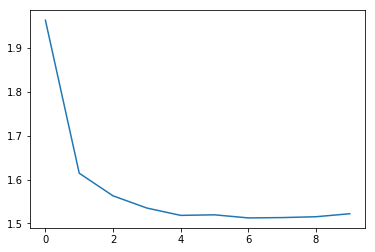

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

# Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [79]:
print(evaluate('Professor Moriarty', 200, temperature=0.5))

Professor Moriarty
 and all entered from the sear a singure at the good of the state
 address of his carriage not of the pather which he drawger in the whole.

 "'You convern the with the sitte of a floor and my draw. 


In [41]:
print(evaluate('Holm', 200, temperature=1.4))

Holmend him? Condrss,' shen
 fince throunds. Maside that tWoughly."

 A jin ttoce ceracfasion Gook."

 "On you ardished cleagage that my Broke then. Excot was
 though. He was only load him votbers Squabst


In [42]:
print(evaluate('Holm', 200, temperature=1.0))

Holmes.  He was sugk
 you have extents?"

 "Yar. Now, With they had so Torner, and not into then my
 kaltia Rost of real into there descridge, with no, here?" Nurt for
 sharm to this atterment for her.

 


In [45]:
print(evaluate('Holm', 200, temperature=0.9))

Holmes. Now, glorious
 hif her whethere had a roughing his well and a lamberniscrister came wife,
 but, and led coudrey content upon a caskipe. You outent of the ensidectaress
 threas clue on these of out


In [48]:
print(evaluate('Holm', 200, temperature=0.8))

Holmes his chore, and he, which his not, and
 still be the assuals the inspector for the elare which he met a speceme of pains and a
 other mapable gain of the grassores, it.

 "You was the bore?"

 "You 


In [61]:
print(evaluate('Holm', 200, temperature=0.7))

Holmes, we quite world on the one
 the week and that dead the good, have the whower the man and side of his conside
 of conside of the pharise at us in an nention. He are do the last
 has say and so house


In [60]:
print(evaluate('Holm', 200, temperature=0.6))

Holmes who seen an and be a
 constrange."

 "There force out and the confess a shoulder?' asked Holmes, and I have
 she starting it to suspect the persham, the will go before an expector
 and him. The onl


In [58]:
print(evaluate('Holm', 200, temperature=0.5))

Holmes at the man, and
 the same of the man, with the conse which he had been in his should purportance which
 was a looked of the should have to the kept the said at his entered starter and
 the man of t


Lower temperatures are less varied, choosing only the more probable outputs:

In [57]:
print(evaluate('Holm', 200, temperature=0.2))

Holmes and a state of the same
 and a grass of the sight and the past of the second of the man and the side
 and a street the short which he was a conside and he was a statest of the
 state were and a sta


Higher temperatures more varied, choosing less probable outputs:

In [55]:
print(evaluate('Holm', 200, temperature=0.1))

Holmes and a state of the shall and a
 state of the shall present of the shall present of the second of the shall
 starting that the shall of the shall of the state of the shall present and the shall and 


# Exercises

* Train with your own dataset, e.g.
    * Text from another author
    * Blog posts
    * Code
* Increase number of layers and network size to get better results

**Next**: [Generating Names with a Conditional Character-Level RNN](https://github.com/spro/practical-pytorch/blob/master/conditional-char-rnn/conditional-char-rnn.ipynb)